In [ ]:
import numpy as np 


import sys
import os

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 

import scipy
from scipy.special import legendre
import scipy.integrate as integrate

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

# plt.style.use('ggplot')
jax.default_backend()   

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.5
})

## Gaussian Spectrum

In [3]:
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

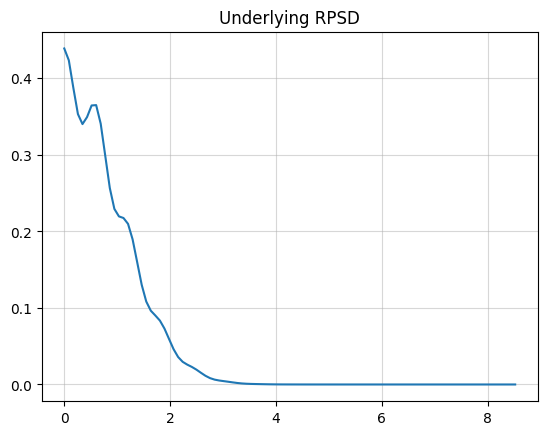

In [4]:
N = 32
M = 2*N - 1
sigma = 1 
w = 2*5*sigma 
w0 = w / M


grid = np.arange(-(N-1),N) 
i,j,k  = np.meshgrid(grid,grid,grid) 
omega_x, omega_y, omega_z = i*w0, j*w0, k*w0
omega_r = np.sqrt(omega_x ** 2 + omega_y ** 2 + omega_z ** 2)

r = np.linspace(0,omega_r.max(),100)
spect = (1/np.sqrt(2*np.pi * sigma ** 2)) * np.exp(- r ** 2 / (2*sigma ** 2)) * (1 + 0.1 * np.cos(10*r))

plt.title("Underlying RPSD")
plt.plot(r,spect);

We run the following experiment with SNR OF 0.1.

Our modeling is of the following:

$$ S_i  = \alpha_i \hat{f} + \mathcal{N}$$

We calculate the SNR by the following equation:

$$ SNR = \frac{\text{Var}(S)}{\text{Var}(\mathcal{N})}$$

In [5]:
SNR = 0.1
std = np.var(spect)/SNR
print(std)

0.13795826846150272


In [6]:
K = 200
N = 32
uniform_points, bins = generate_uniform_radial_sampling_points(N)
H, samples =  generate_gaussian_rpsd_data(K,N,std)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/rpsd_test_data.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


In [7]:
max_d = int(np.floor(N/3))  
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psds = vect_spectrum_estimation(samples,max_d)

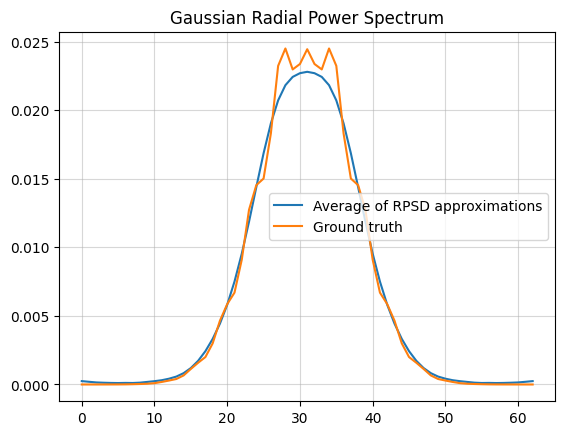

In [8]:
S = H / np.linalg.norm(H)
avg_psd = np.mean(psds,axis=0)
avg_psd /= np.linalg.norm(avg_psd)
plt.title("Gaussian Radial Power Spectrum")
plt.plot(avg_psd[N,N,:], label='Average of RPSD approximations')
plt.plot(S[N,N,:], label='Ground truth')
plt.legend();

In [9]:
rblocks = np.array([radial_average(psds[k], bins, N) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_1044840/2355446449.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


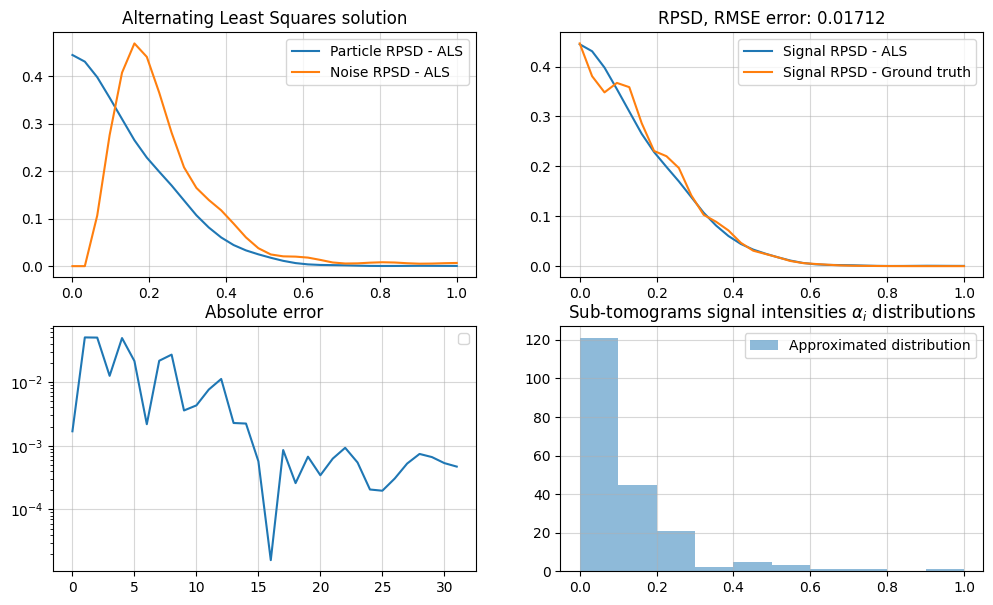

In [15]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
#ax[0,1].set_yscale('log')
ax[0,1].set_title("RPSD benchmark")
ax[0,1].set_title(f"RPSD, RMSE error: {np.sqrt(np.mean((true_rpsd - particle_psd)**2)):.5f}")
ax[0,1].legend()

ax[1,0].set_title("Absolute error")
ax[1,0].plot(np.abs(true_rpsd - particle_psd))
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].set_title(r"Sub-tomograms signal intensities $ \alpha_i$ distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

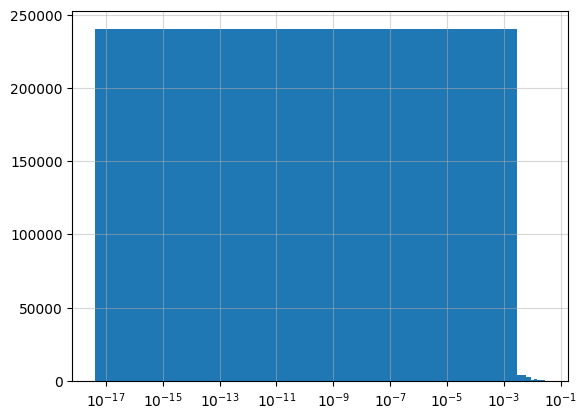

In [20]:
plt.hist(H.flatten())
plt.xscale('log');

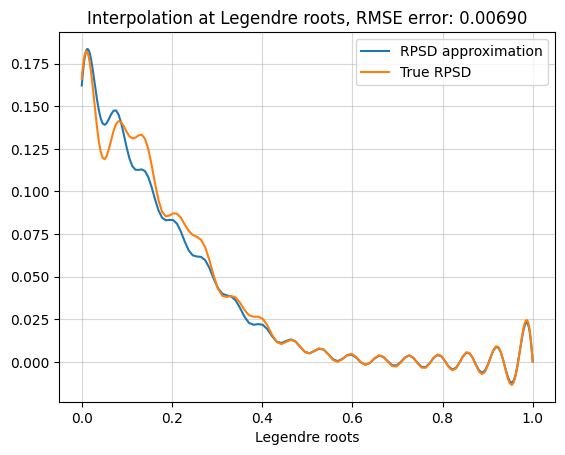

In [25]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
Gx /= np.linalg.norm(Gx)
Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
Gx_true /= np.linalg.norm(Gx_true)
plt.title("RPSD interpolation")
plt.plot(X_scaled, Gx, label='RPSD approximation')
plt.plot(X_scaled, Gx_true, label='True RPSD')
plt.title(f"Interpolation at Legendre roots, RMSE error: {np.sqrt(np.mean((Gx_true - Gx)**2)):.5f}")
plt.xlabel("Legendre roots")
plt.legend();

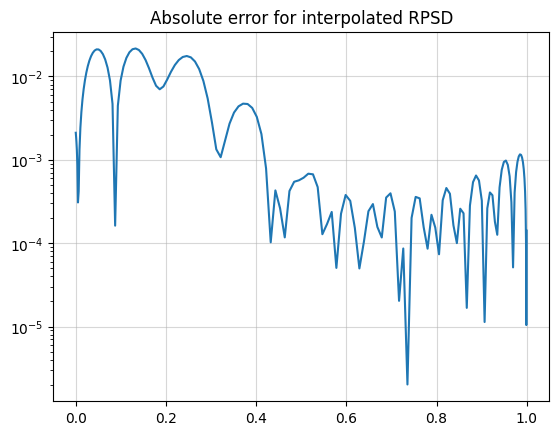

In [12]:
plt.title("Absolute error for interpolated RPSD")
plt.yscale('log')
plt.plot(X_scaled,np.abs(Gx_true - Gx));

The low frequencies contribute large relative errors, it's not clear yet how much can reduce the error on his frequency cut-off.

### Fixed Fredholm solver + Orthogonality check

Following derivation I did we show that for the eigenfunctions $\psi_{N,m,n} = R_{N,n}Y_{N}^m(\theta, \psi)$ to be orthogonal we must have the radial functions be orthogonal under the $L_2$ inner-product equipped $x^2$ measure:

$$ \langle f,g \rangle = \int_{\Omega} f(x) g(x) x^2 dx $$

Note that this requires us to do some modifications to the integral equation to be in the form:

$$ \lambda R(r) = \int_{0}^1 \Psi_N(r,r')R(r')r'^{2} dr'$$

So the resulting eigenfunctions respect the measure $x^2dx$ and $\Psi_N$ is symmetric.


$$ H = \{ \Psi(r_i, r_j) \} $$

Note that although $ H = \{ \Psi(r_i, r_j) \} $ is symmetric, when we discretize the integral equation we need that Jacobian term and the Legendre weights making the matrix $A = HW$ not symmetric. 
This introduce instability and errors and solutions and doesn't enforce the required orthogonality. So instead we solve that following:

Note that although $ H= \{ \Psi_N(r_i,r_j) \}$ is symmetric, when we discretize the integral equation we need that Jacobian term and the Legendre weights making the matrix $A = HW$ not symmetric. 
This introduce instability and errors and solutions and doesn't enforce the required orthogonality. So instead we solve that following: $ Ay = \lambda y$.

For $A=W^{1/2}H W^{1/2}$ and $y=W^{1/2}R$. If you open the new expression we see it's equivalent for the old one. So to restore $R$ we calculate $ R = W^{-1/2}R$.

Important observation I found is that our $H_n$ function is exactly the Spherical Bessel functions. Using the plane wave expansion:

$$ e^{ix \cos \theta} = \sum_{\ell = 0}^{\infty} (2\ell + 1) i^{\ell} j_{\ell}(x) P_\ell(\cos \theta)$$

We see that $j_{\ell}$ is exactly defined by the inner product of the complex exponent with the Legendre polynomials.

Ref: https://scipp.ucsc.edu/~haber/ph215/PlaneWaveExpansion.pdf

NOTE: It was already checked numerically to have machine precision.

In [13]:
from scipy.special import spherical_jn 


def fredholm_solver(Gx,N,K=150):
    def Hn(x):
        return 2*np.pi * (2*(1j**N) * spherical_jn(N,x))

    X,w = scipy.special.roots_legendre(K)
    X_scaled = 0.5*X + 0.5

    vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])

    def psi_even(i,j):
        return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled)**2)
    
    def psi_odd(i,j):
        return 0.5 * np.sum(w * (-vv[j,:]) * vv[i,:] * Gx * (X_scaled)**2)

    psi = psi_even if N % 2 == 0 else psi_odd
    H = np.array([[psi(j,i) for j in range(K)] for i in range(K)])
    W = np.diag(w*(X_scaled)**2)
    
    # Make H symmetric for stable solution
    A = np.sqrt(W) @ H @ np.sqrt(W)    
    eigvals, Y = np.linalg.eigh(A)
    R = np.linalg.solve(np.sqrt(W), Y) 

    eigvals = eigvals[::-1]
    eigfuncs = R[:,::-1]
    return eigvals, eigfuncs, W

/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


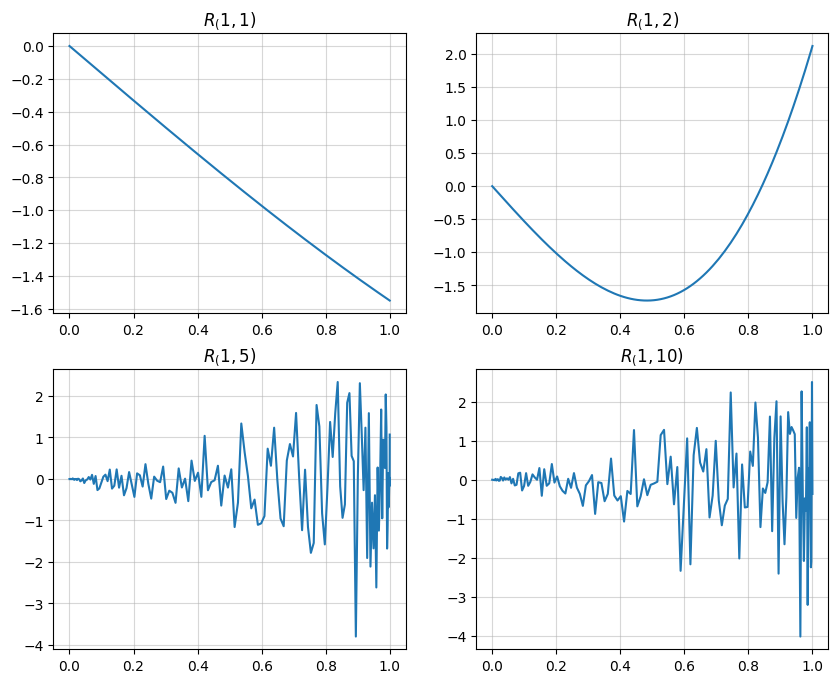

In [14]:
order = 1
eigenvalues, eigenfunctions,W = fredholm_solver(Gx,order)

fig, ax = plt.subplots(2,2, figsize=(10,8))


ax[0,0].plot(X_scaled,eigenfunctions[:,0])
ax[0,0].set_title(f"$R_{order,1}$")

ax[0,1].plot(X_scaled,eigenfunctions[:,1])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,4])
ax[1,0].set_title(f"$R_{order,5}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,9])
ax[1,1].set_title(f"$R_{order,10}$");

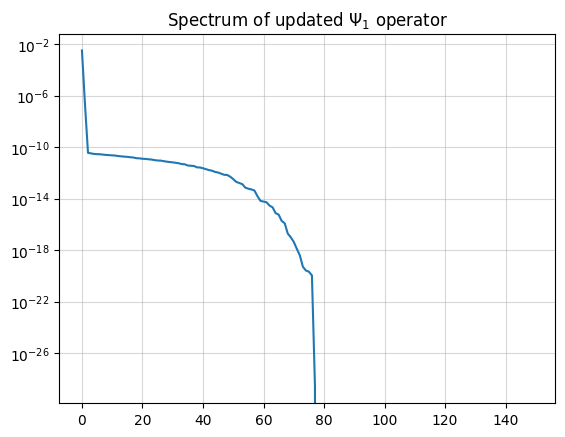

In [15]:
plt.title("Spectrum of updated $\Psi_1$ operator")
plt.plot(eigenvalues)
plt.yscale('log');

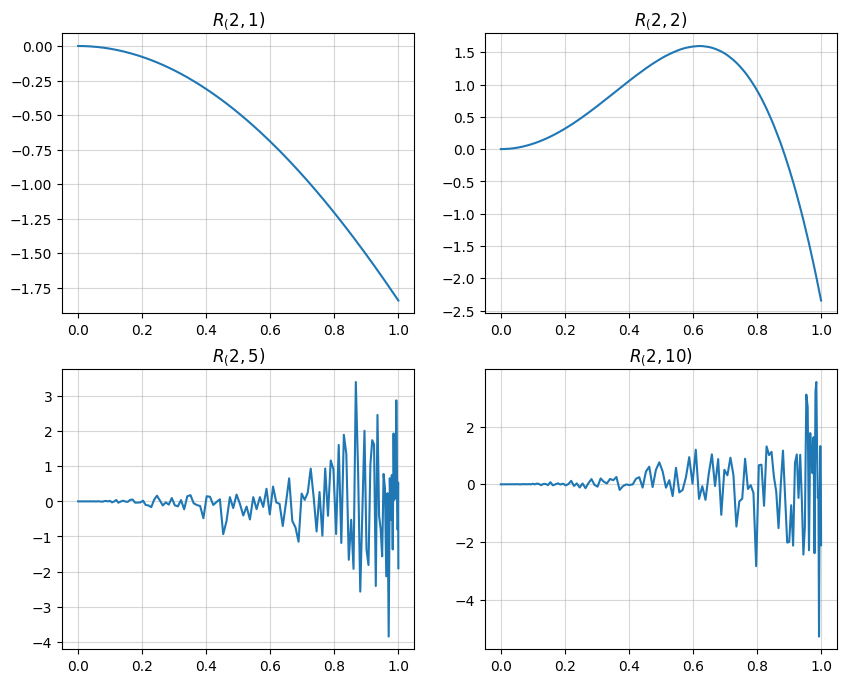

In [17]:
order = 2
eigenvalues, eigenfunctions,W = fredholm_solver(Gx,order)

fig, ax = plt.subplots(2,2, figsize=(10,8))


ax[0,0].plot(X_scaled,eigenfunctions[:,0])
ax[0,0].set_title(f"$R_{order,1}$")

ax[0,1].plot(X_scaled,eigenfunctions[:,1])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,4])
ax[1,0].set_title(f"$R_{order,5}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,9])
ax[1,1].set_title(f"$R_{order,10}$");

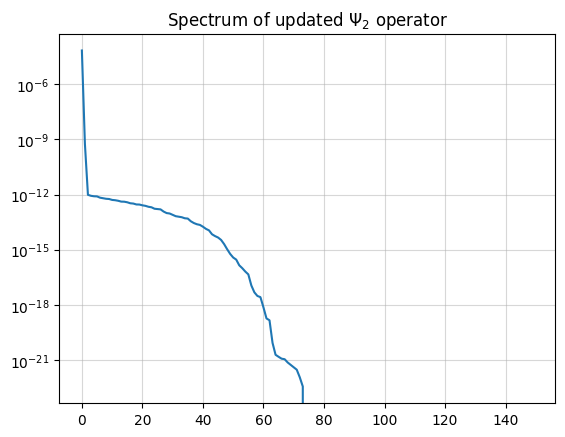

In [18]:
plt.title("Spectrum of updated $\Psi_2$ operator")
plt.plot(eigenvalues)
plt.yscale('log');

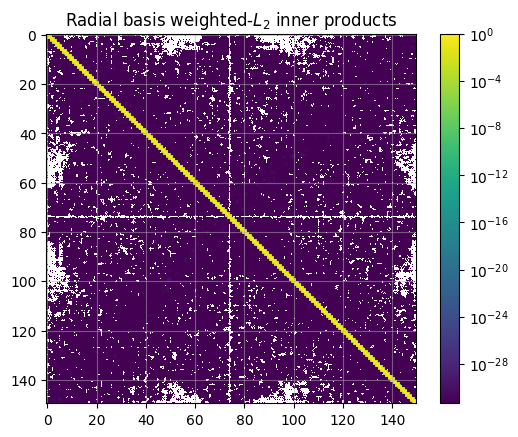

In [19]:
from matplotlib.colors import LogNorm

W = np.diag(w*(X_scaled)**2)
inner_prods = eigenfunctions.T @ W @ eigenfunctions
plt.imshow(np.abs(inner_prods), norm=LogNorm())
plt.title("Radial basis weighted-$L_2$ inner products")
plt.colorbar();

In [63]:
orders = np.arange(10)

eigvals = []
eigfuncs = []
for order in np.arange(10):
    eigenvalues, eigenfunctions, W = fredholm_solver(Gx,order)
    eigvals.append(eigenvalues)
    eigfuncs.append(eigenfunctions)

In [65]:
eigfuncs = np.array(eigfuncs).reshape(-1,150)
eigvals = np.array(eigvals).reshape(-1)

idx = np.argsort(eigvals)

eigfuncs = eigfuncs[idx,:]
eigvals = eigvals[idx]

idx = np.where(eigvals > np.spacing(1))[0]
eigvals = eigvals[idx][::-1]
eigfuncs = eigfuncs[idx,:][::-1,:]

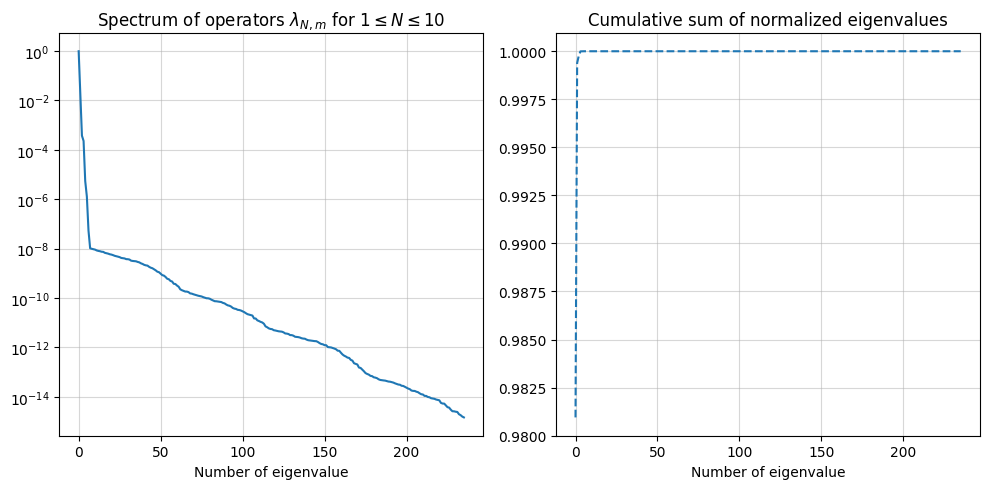

In [72]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title(r"Spectrum of operators $\lambda_{N,m}$ for $1 \leq N \leq 10$")
ax[0].plot(eigvals/np.sum(eigvals))
ax[0].set_xlabel("Number of eigenvalue")
ax[0].set_yscale('log');

ax[1].set_title("Cumulative sum of normalized eigenvalues")
eigvals_sum = np.cumsum(eigvals/np.sum(eigvals))
ax[1].plot(eigvals_sum,'--')
ax[1].set_xlabel("Number of eigenvalue")

plt.tight_layout();

Note the solutions are of the form:

$$ \psi_{N,m,n}(r,\theta,\phi) = R_{N,m}(r) Y_N^m(\theta,\phi)$$

This function is 4-dimensional hence instead we will visualize slices of it. As the Spherical Harmonics are defined:

$ Y_N^{m} ( \theta, \phi ) =  \sqrt{\frac{2N+1}{4 \pi} \frac{(N-m)!}{(N+m)!}} e^{im\theta} P_N^m(\cos(\phi)) $

We cana fix $ \phi=0$ and plot the eigenfunction up to a constant.

/tmp/ipykernel_940919/3311782016.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d, cmap='seismic')


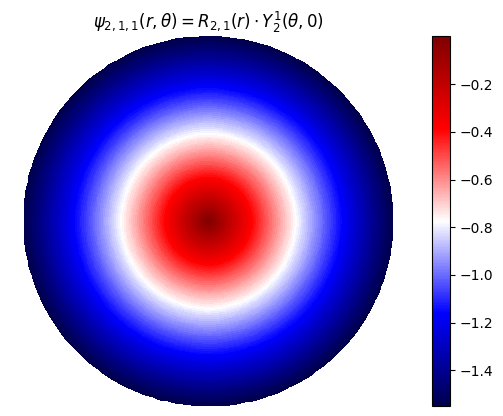

In [86]:
order = 1
eigenvalues, eigenfunctions,W = fredholm_solver(Gx,order)

N = 150 
R = eigenfunctions[:,0].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)

R_2d = np.tile(R[:, np.newaxis], (1, N))
plt.pcolormesh(X, Y, R_2d, cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{2,1,1}(r, \theta) = R_{2,1}(r) \cdot Y_2^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');

/tmp/ipykernel_940919/2768769189.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d,cmap='seismic')


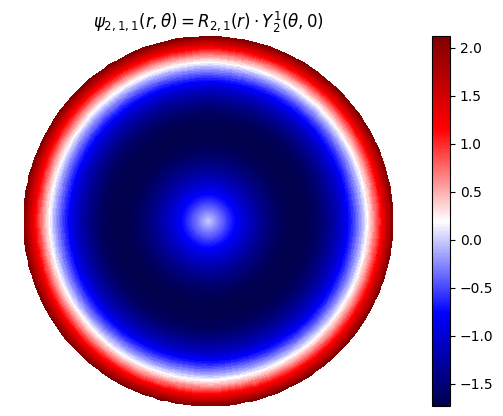

In [87]:
R = eigenfunctions[:,1].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)

R_2d = np.tile(R[:, np.newaxis], (1, N))
plt.pcolormesh(X, Y, R_2d,cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{2,1,1}(r, \theta) = R_{2,1}(r) \cdot Y_2^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');

## Power Law Spectra

In [76]:
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

In [79]:
K = 200
N = 32
M = 2*N - 1 
max_d = int(np.floor(N/2))
 
uniform_points, bins = generate_uniform_radial_sampling_points(N)

T = -np.log(1e-15)/30
grid = np.arange(-(N-1),N)
i,j,k = np.meshgrid(grid,grid,grid)
r = np.sqrt(i**2 + j**2 + k**2) 
H = 1/(( 1+ r**2) ** 0.5)
C = M**3 / H.sum()
normalized_H = jnp.fft.ifftshift(jnp.sqrt(H * C))


window = np.bartlett(M)
samples = np.zeros((K,N,N,N))
alphas = np.random.beta(2,5,size=(K))   
std = 0.01
for i in range(K):
    gaussian_noise = np.random.normal(size=(M,M,M))
    additive_noise = np.random.normal(scale=std,size=(M,M,M))
    sample = jnp.fft.ifftn(jnp.fft.fftn(gaussian_noise) * normalized_H)
    sample = alphas[i]*sample + additive_noise
    samples[i] = sample[:N,:N,:N]

S = H / np.linalg.norm(H)

/tmp/ipykernel_597644/1736236541.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[i] = sample[:N,:N,:N]


In [80]:
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psds = vect_spectrum_estimation(samples,max_d)

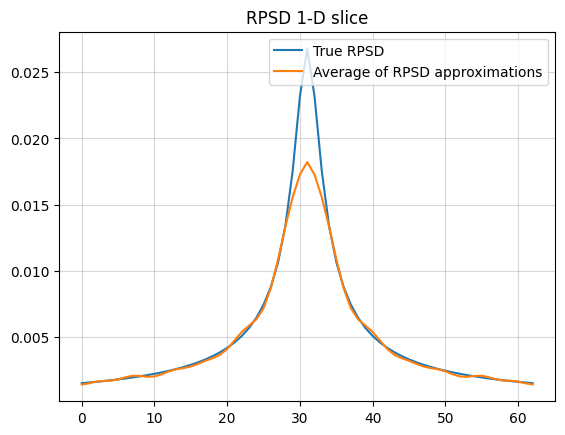

In [81]:
avg_psd = np.mean(psds,axis=0)
avg_psd /= np.linalg.norm(avg_psd)
plt.title("RPSD 1-D slice")
plt.plot(S[N,N,:], label='True RPSD')
plt.plot(avg_psd[N,N,:], label="Average of RPSD approximations")
plt.legend();

In [82]:
rblocks = np.array([radial_average(psds[k], bins, N) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_597644/1911072950.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


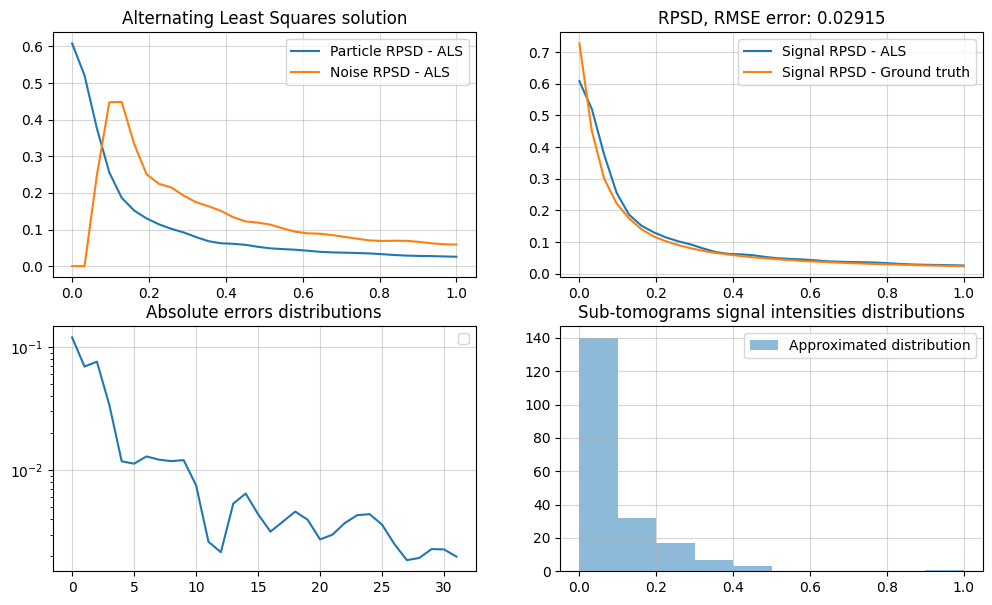

In [88]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title(f"RPSD, RMSE error: {np.sqrt(np.mean((true_rpsd - particle_psd)**2)):.5f}")

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].plot(np.abs(true_rpsd - particle_psd))
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

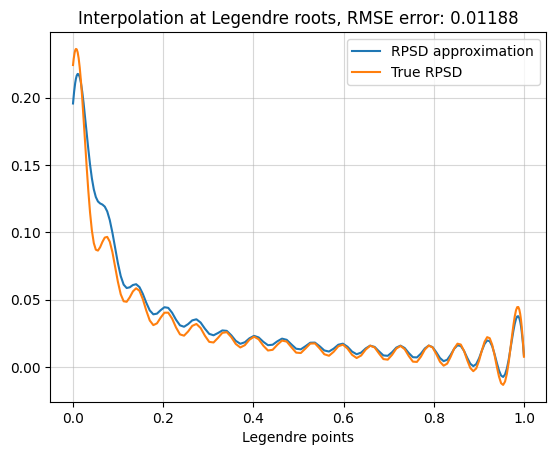

In [89]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
Gx /= np.linalg.norm(Gx)
Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
Gx_true /= np.linalg.norm(Gx_true)
plt.title("RPSD interpolation")
plt.plot(X_scaled, Gx, label='RPSD approximation')
plt.plot(X_scaled, Gx_true, label='True RPSD')
plt.title(f"Interpolation at Legendre roots, RMSE error: {np.sqrt(np.mean((Gx_true - Gx)**2)):.5f}")
plt.xlabel("Legendre points")
plt.legend();

In [ ]:
from scipy.special import spherical_jn 


def fredholm_solver(Gx,N,K=150):
    def Hn(x):
        return 2*np.pi * (2*(1j**N) * spherical_jn(N,x))

    X,w = scipy.special.roots_legendre(K)
    X_scaled = 0.5*X + 0.5

    vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])

    def psi_even(i,j):
        return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled)**2)
    
    def psi_odd(i,j):
        return 0.5 * np.sum(w * (-vv[j,:]) * vv[i,:] * Gx * (X_scaled)**2)

    psi = psi_even if N % 2 == 0 else psi_odd
    H = np.array([[psi(j,i) for j in range(K)] for i in range(K)])
    W = np.diag(w*(X_scaled)**2)
    
    # Make H symmetric for stable solution
    A = np.sqrt(W) @ H @ np.sqrt(W)    
    eigvals, Y = np.linalg.eigh(A)
    R = np.linalg.solve(np.sqrt(W), Y) 

    eigvals = eigvals[::-1]
    eigfuncs = R[:,::-1]
    return eigvals, eigfuncs, W

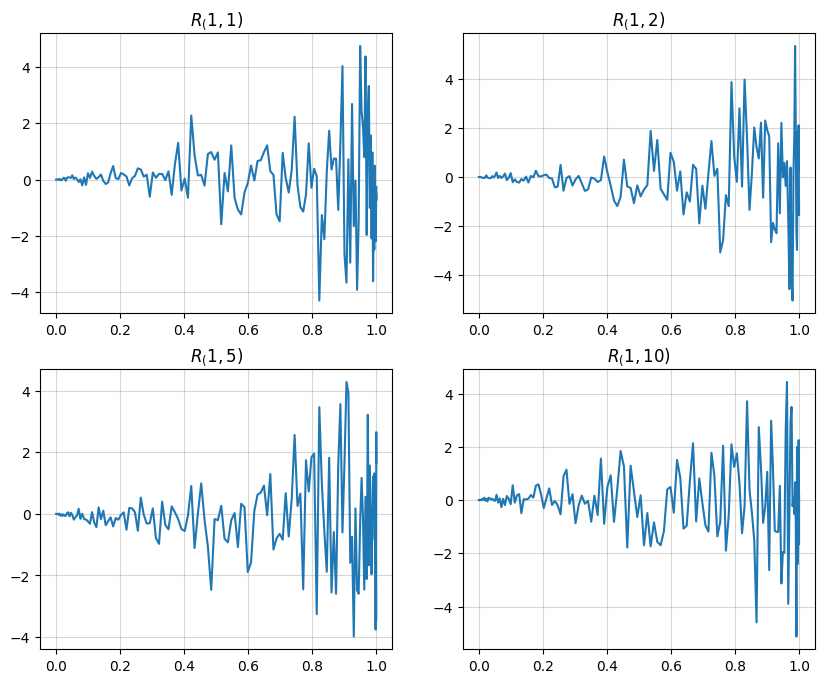

In [98]:
order = 1
eigenvalues, eigenfunctions,W = fredholm_solver(Gx,order)

fig, ax = plt.subplots(2,2, figsize=(10,8))


ax[0,0].plot(X_scaled,eigenfunctions[:,0])
ax[0,0].set_title(f"$R_{order,1}$")

ax[0,1].plot(X_scaled,eigenfunctions[:,1])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,4])
ax[1,0].set_title(f"$R_{order,5}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,9])
ax[1,1].set_title(f"$R_{order,10}$");

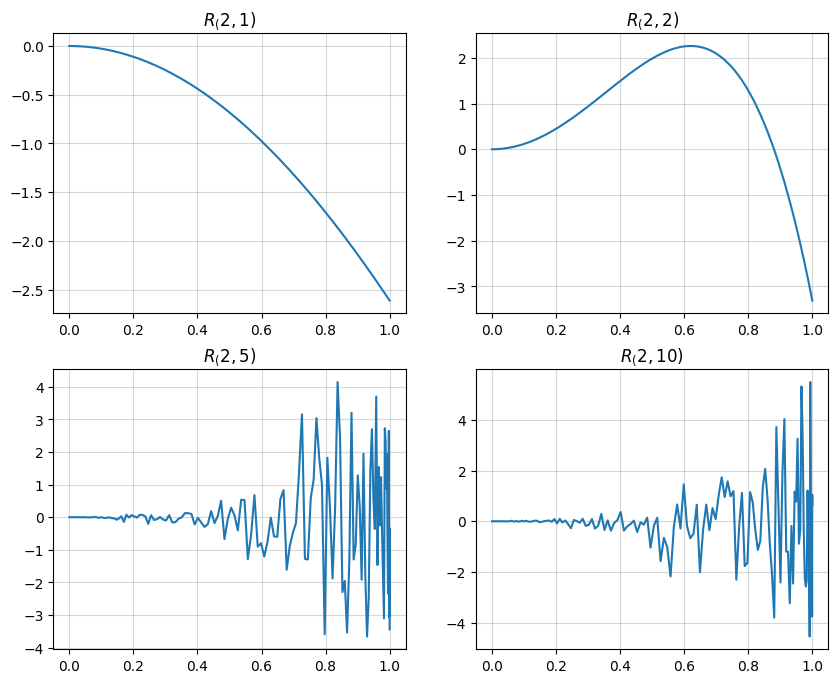

In [100]:
order = 2
eigenvalues, eigenfunctions,W = fredholm_solver(Gx,order)

fig, ax = plt.subplots(2,2, figsize=(10,8))


ax[0,0].plot(X_scaled,eigenfunctions[:,0])
ax[0,0].set_title(f"$R_{order,1}$")

ax[0,1].plot(X_scaled,eigenfunctions[:,1])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,4])
ax[1,0].set_title(f"$R_{order,5}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,9])
ax[1,1].set_title(f"$R_{order,10}$");

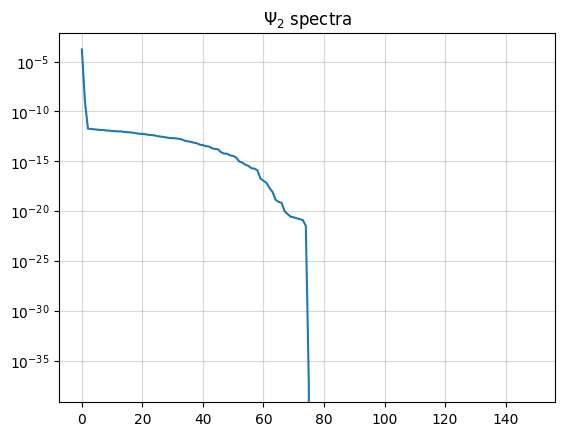

In [101]:
plt.title("$\Psi_2$ spectra")
plt.plot(eigenvalues)
plt.yscale('log');

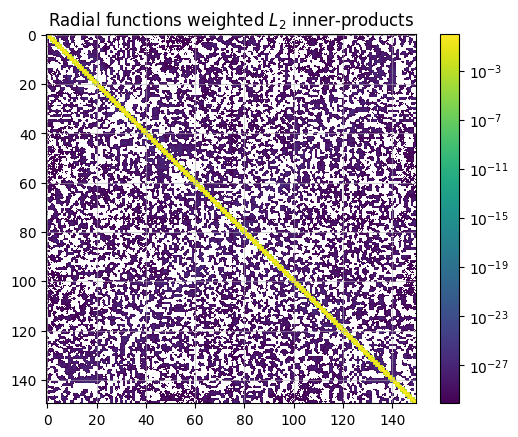

In [106]:
from matplotlib.colors import LogNorm

W = np.diag(0.5*w*(X_scaled)**2)
inner_prods = eigenfunctions.T @ W @ eigenfunctions
#inner_prods[np.eye(150,dtype=bool)] = 0
plt.imshow(inner_prods, norm=LogNorm())
plt.title("Radial functions weighted $L_2$ inner-products")
plt.colorbar();

/tmp/ipykernel_597644/3641769778.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d,cmap='seismic')


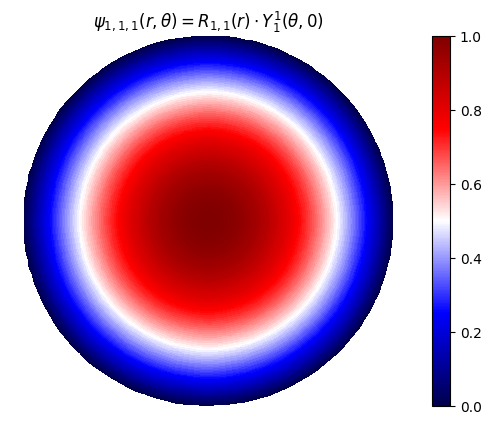

In [107]:
N = 150 
R = eigenfunctions[:,0].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)


R_norm = 2*(R - R.min())/(R.max() - R.min()) - 1
R_colors = 0.5*(R_norm + 1)
R_2d = np.tile(R_colors[:, np.newaxis], (1, N))

plt.pcolormesh(X, Y, R_2d,cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{1,1,1}(r, \theta) = R_{1,1}(r) \cdot Y_1^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');

Notes to self:
- The interpolated RPSD seems to be quite similar in result. Needs to check it on the actual value by radial averaing over the X_scaled as magnitudes. 
- The results of Fredholm solver seems a bit too much redundant? I'm not sure if it's expected to have so much little data in high orders eigenvalues for a fixed N. 
- When tested on a slower PSD the resulting RPSD seemed a bit off, why? 
- The Fredholm equation is integreated up to a or c (bandwith of particle's function and diameter of particle). What if it's bigger than 1? How can one interpolate the RPSD well? 